# Imports

In [6]:
import random
import math
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import special

import torch 
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchsummary import summary

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda') 
print('device : ', device)
print('num gpu : ', torch.cuda.device_count())

device :  cuda
num gpu :  4


In [8]:
# torch.manual_seed(1234)
# np.random.seed(1234)
# random.seed(1234)

# Generate Data

In [263]:
class StepDataset(data.Dataset):
    
    def __init__(self, upper=5, lower=-3, length=100, error_range=0.1, center=1, ymax=1., x_var=None, y_var=None, model_mean=None):
        self.upper = upper
        self.lower = lower
        self.length = length
        self.error_range = error_range
        self.y_var = y_var
        if self.y_var != None:
            self.noise = np.array([np.random.normal(center,self.y_var) for i in range(self.length)]).reshape(-1,1).astype(np.float32)
        else:
            self.noise = np.array([2 * self.error_range * np. random.rand() - self.error_range for i in range(self.length)]).reshape(-1,1).astype(np.float32)
            self.y_var = (2*self.error_range)**2/12
        
        if x_var != None:
            self.input = np.array([[(self.upper - self.lower) * np. random.rand() + self.lower, x_var] for i in range(self.length)]).astype(np.float32)
            self.output = np.array([[x.item()*ymax,self.y_var] for x in (self.input[:,0]>center)]).astype(np.float32)
            self.output[:,0] += self.noise.reshape(-1)
        else:    
            self.input = np.array([(self.upper - self.lower) * np. random.rand() + self.lower for i in range(self.length)]).reshape(-1,1).astype(np.float32)
            self.output = (ymax * (self.input > center) + self.noise).astype(np.float32)
            if model_mean!=None:
                pred = model_mean(torch.tensor(self.input)).to("cpu")
                self.output = torch.abs(torch.tensor(self.output) - pred)


    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        x = self.input[index]
        y = self.output[index]
        
        return x, y

In [264]:
dataset = StepDataset(ymax=4.)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
x, y = next(iter(dataloader))
x.shape

torch.Size([100, 1])

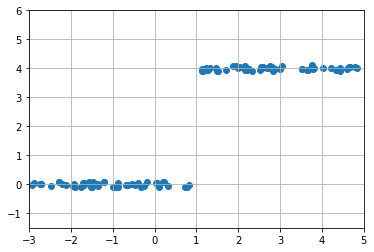

In [267]:
# dataset = StepDataset(ymax=4.)
dataset = StepDataset(5,-3,100,0.1,center=1,ymax=4.)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
x, y = next(iter(dataloader))
x = x[:,0]
y = y[:,0]


plt.scatter(x, y)
plt.xlim(-3, 5)
plt.ylim(-1.5, 6.)
plt.grid()
plt.show()

# Basic Regression Model

## Modeling

In [12]:
class BasicRegressor(nn.Module):
    
    def __init__(self):
        super(BasicRegressor, self).__init__()
        self.layer1 = nn.Linear(1, 200)
        self.layer2 = nn.Linear(200, 200)
        self.last = nn.Linear(200, 1)
        self.dropout = nn.Dropout(p=0.01)
        
    def forward(self, x):
        out = self.layer1(x)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.last(out)
        
        return out

In [13]:
net = BasicRegressor().to(device)
print(net)
summary(net,(1,))

BasicRegressor(
  (layer1): Linear(in_features=1, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=200, bias=True)
  (last): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]             400
           Dropout-2                  [-1, 200]               0
            Linear-3                  [-1, 200]          40,200
           Dropout-4                  [-1, 200]               0
            Linear-5                    [-1, 1]             201
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.16
Estimated Total Size (MB): 0.16
--------------------------------------------------

In [14]:
net = BasicRegressor()
net(torch.tensor([[0.]]))

tensor([[0.0152]], grad_fn=<AddmmBackward>)

## Train

### Mean Model

In [42]:
def train_mean(model, dataloader, num_epochs):   
    model = nn.DataParallel(model)
    model.to(device)
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):      
        t_epoch_start = time.time()
        epoch_loss = 0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        for data in dataloader:       
            batch_size = len(data[0])
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Loss:{:.4f} '.format(epoch, epoch_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        
    model.eval()        
    return model

In [337]:
dataset = StepDataset(5,-3,100,error_range=0.1,center=1,ymax=4.)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle=True)

model_mean = BasicRegressor()
model_mean = train_mean(model_mean, dataloader,100)

-------------
Epoch 1/100
-------------
-------------
epoch 0 || Loss:6.6511 
timer:  0.0514 sec.
-------------
Epoch 2/100
-------------
-------------
epoch 1 || Loss:2.3384 
timer:  0.0732 sec.
-------------
Epoch 3/100
-------------
-------------
epoch 2 || Loss:2.1625 
timer:  0.0548 sec.
-------------
Epoch 4/100
-------------
-------------
epoch 3 || Loss:1.8226 
timer:  0.0651 sec.
-------------
Epoch 5/100
-------------
-------------
epoch 4 || Loss:1.6064 
timer:  0.0956 sec.
-------------
Epoch 6/100
-------------
-------------
epoch 5 || Loss:1.5157 
timer:  0.0680 sec.
-------------
Epoch 7/100
-------------
-------------
epoch 6 || Loss:1.4416 
timer:  0.0548 sec.
-------------
Epoch 8/100
-------------
-------------
epoch 7 || Loss:1.2784 
timer:  0.0573 sec.
-------------
Epoch 9/100
-------------
-------------
epoch 8 || Loss:1.2899 
timer:  0.0595 sec.
-------------
Epoch 10/100
-------------
-------------
epoch 9 || Loss:1.0487 
timer:  0.0549 sec.
-------------
Epoch

-------------
epoch 82 || Loss:0.1453 
timer:  0.0593 sec.
-------------
Epoch 84/100
-------------
-------------
epoch 83 || Loss:0.1532 
timer:  0.0490 sec.
-------------
Epoch 85/100
-------------
-------------
epoch 84 || Loss:0.1735 
timer:  0.0566 sec.
-------------
Epoch 86/100
-------------
-------------
epoch 85 || Loss:0.1240 
timer:  0.0483 sec.
-------------
Epoch 87/100
-------------
-------------
epoch 86 || Loss:0.1756 
timer:  0.0482 sec.
-------------
Epoch 88/100
-------------
-------------
epoch 87 || Loss:0.1193 
timer:  0.0722 sec.
-------------
Epoch 89/100
-------------
-------------
epoch 88 || Loss:0.1462 
timer:  0.0676 sec.
-------------
Epoch 90/100
-------------
-------------
epoch 89 || Loss:0.3290 
timer:  0.0643 sec.
-------------
Epoch 91/100
-------------
-------------
epoch 90 || Loss:0.1950 
timer:  0.0597 sec.
-------------
Epoch 92/100
-------------
-------------
epoch 91 || Loss:0.1545 
timer:  0.0383 sec.
-------------
Epoch 93/100
-------------


### Error Model

In [60]:
# dataset = StepDataset(ymax=4., model_mean=model_mean)
# dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
# x, y = next(iter(dataloader))
# y

In [280]:
class CustomLoss(nn.Module):
    
    def __init__(self, beta=0.1):
        super(CustomLoss, self).__init__()
        self.beta = beta
        
    def forward(self, x, y):
        dist = torch.sum(
            torch.pow((y - x).clamp(min=0.),2) + self.beta*torch.pow((y - x).clamp(max=0.),2)
            )
        loss = dist/(x.shape[0]*x.shape[1])
        return loss

In [281]:
def train_error(model, dataloader, num_epochs):   
    model = nn.DataParallel(model)
    model.to(device)
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters())
    criterion = CustomLoss(beta=0.1)
    
    for epoch in range(num_epochs):      
        t_epoch_start = time.time()
        epoch_loss = 0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        for data in dataloader:       
            batch_size = len(data[0])
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            
            epoch_loss += loss.item()
            
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Loss:{:.4f} '.format(epoch, epoch_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        
    model.eval()        
    return model

In [338]:
dataset = StepDataset(5,-3,100,error_range=0.1,center=1,ymax=4.,model_mean=model_mean)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle=True)

model_error = BasicRegressor()

model_error = train_error(model_error, dataloader, 100)

-------------
Epoch 1/100
-------------
-------------
epoch 0 || Loss:0.2780 
timer:  0.0764 sec.
-------------
Epoch 2/100
-------------
-------------
epoch 1 || Loss:0.2295 
timer:  0.0651 sec.
-------------
Epoch 3/100
-------------
-------------
epoch 2 || Loss:0.1737 
timer:  0.0555 sec.
-------------
Epoch 4/100
-------------
-------------
epoch 3 || Loss:0.1393 
timer:  0.0787 sec.
-------------
Epoch 5/100
-------------
-------------
epoch 4 || Loss:0.1234 
timer:  0.0627 sec.
-------------
Epoch 6/100
-------------
-------------
epoch 5 || Loss:0.1318 
timer:  0.0652 sec.
-------------
Epoch 7/100
-------------
-------------
epoch 6 || Loss:0.1147 
timer:  0.0716 sec.
-------------
Epoch 8/100
-------------
-------------
epoch 7 || Loss:0.1042 
timer:  0.0714 sec.
-------------
Epoch 9/100
-------------
-------------
epoch 8 || Loss:0.0936 
timer:  0.1050 sec.
-------------
Epoch 10/100
-------------
-------------
epoch 9 || Loss:0.1123 
timer:  0.0611 sec.
-------------
Epoch

-------------
epoch 82 || Loss:0.0145 
timer:  0.0587 sec.
-------------
Epoch 84/100
-------------
-------------
epoch 83 || Loss:0.0190 
timer:  0.0706 sec.
-------------
Epoch 85/100
-------------
-------------
epoch 84 || Loss:0.0307 
timer:  0.0886 sec.
-------------
Epoch 86/100
-------------
-------------
epoch 85 || Loss:0.0237 
timer:  0.0573 sec.
-------------
Epoch 87/100
-------------
-------------
epoch 86 || Loss:0.0202 
timer:  0.0733 sec.
-------------
Epoch 88/100
-------------
-------------
epoch 87 || Loss:0.0151 
timer:  0.0718 sec.
-------------
Epoch 89/100
-------------
-------------
epoch 88 || Loss:0.0176 
timer:  0.0684 sec.
-------------
Epoch 90/100
-------------
-------------
epoch 89 || Loss:0.0143 
timer:  0.0831 sec.
-------------
Epoch 91/100
-------------
-------------
epoch 90 || Loss:0.0160 
timer:  0.0884 sec.
-------------
Epoch 92/100
-------------
-------------
epoch 91 || Loss:0.0138 
timer:  0.0960 sec.
-------------
Epoch 93/100
-------------


## Validation

/home/yashima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]


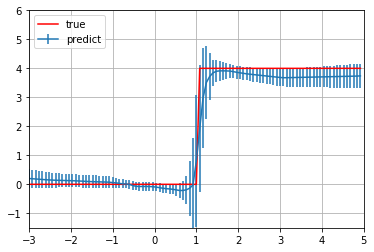

In [339]:
length = 100
start = -3
end = 5
waith = end - start
val_x = torch.tensor([[i] for i in np.arange(start,end,waith/length)])
val_y = (val_x>1)*4
pred_y = model_mean(val_x).detach().cpu()
pred_std = model_error(val_x).detach().cpu()


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar(val_x, pred_y, pred_std, label="predict")
ax.plot(val_x, val_y, label="true",c="red")
ax.grid()
ax.legend(loc='upper left')
plt.xlim(-3, 5)
plt.ylim(-1.5, 6)
fig.show()

# Stochastic Reression

## Modeling

### Modified ReLU

In [248]:
def ReLUGauss(mu_in, var_in, epsilon=1.0e-6, cut_sd=4.0):
    mu_out = torch.zeros(mu_in.shape[0], mu_in.shape[1])
    var_out = torch.zeros(var_in.shape[0], var_in.shape[1])
    mu = mu_in
    var = var_in
    sigma = torch.sqrt(var+1e-16)

    if (var < 0).any().item(): raise Exception(f"ERROR in ReLUGauss: 'var_in' should be all positive value, but it has negative value.")
    idx_SmallSigma = (sigma < epsilon)
    if cut_sd != None:
        idx_LargeMu = (mu > cut_sd*sigma)
        idx_SmallMU = (mu < -cut_sd*sigma)

    sqrt2 = math.sqrt(2.0)
    sqrt2pi = math.sqrt(2.0*math.pi)    
    z = mu / (sqrt2*sigma+1e-16)
    E = torch.erf(z)
    X = torch.exp(-z*z)
    mu_out = sigma/sqrt2pi*X + mu/2.0*(1.0+E)
    var_out = (1.0+E)/4.0*(mu*mu*(1.0-E)+2.0*var) - sigma*X/sqrt2pi*(sigma*X/sqrt2pi+mu*E)
    
    idx_SmallVarOut = (var_out<0.0)*(var_out>-epsilon)
    isError = ((var_out<0.0)*(var_out<=-epsilon)).any().item()
    if isError:
        msg= f'ERROR in ReLUGauss: (mu: {mu}\n, sigma: {sigma}\n, mu_out: {mu_out}\n, var_out: {var_out}\n)'
        print(msg)
        raise Exception(msg)


    mu_out = mu_out*~idx_SmallSigma + idx_SmallSigma*torch.relu(mu)
    var_out *= ~idx_SmallSigma
    if cut_sd != None:
        mu_out = mu_out*~(idx_LargeMu*~idx_SmallSigma) + (idx_LargeMu*~idx_SmallSigma)*mu
        var_out = var_out*~(idx_LargeMu*~idx_SmallSigma) + (idx_LargeMu*~idx_SmallSigma)*var
        mu_out = mu_out*~(idx_SmallMU*~(idx_LargeMu|idx_SmallSigma))
        var_out = var_out*~(idx_SmallMU*~(idx_LargeMu|idx_SmallSigma))
        var_out = var_out*~(idx_SmallVarOut*~((idx_LargeMu|idx_SmallSigma)|idx_SmallMU))
    else:
        var_out = var_out*~(idx_SmallVarOut*~idx_SmallSigma)
            
    var_out = torch.diag_embed(var_out)
    
    return mu_out, var_out

/home/yashima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


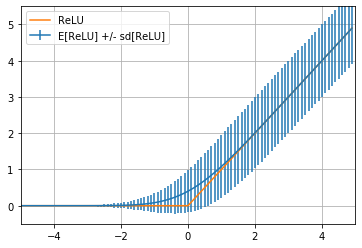

In [275]:
length = 100
start = -5
end = 5
waith = end - start
x = torch.arange(start, end, waith/length).view(-1, 1)
in_var = torch.ones(length, 1)
y, out_var = ReLUGauss(x, in_var)
out_var = out_var.reshape(-1, 1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, torch.sqrt(out_var), label="E[ReLU] +/- sd[ReLU]")
ax.plot(x, torch.relu(x), label="ReLU")
ax.grid()
ax.legend(loc='upper left')
plt.xlim(start, end)
plt.ylim(-0.5, end+0.5)
fig.show()

### Custom DropOut

In [139]:
class CustomDropout(nn.Module):
    
    __constants__ = ['p', 'inplace']

    def __init__(self, p=0.5, inplace=False):
        super(CustomDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(p))
        self.p = p
        self.inplace = inplace
        self.flag = torch.zeros(1,1)
    
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]    
        self.flag = F.dropout(torch.ones(mu_in.shape[0], mu_in.shape[1]), self.p, self.training, self.inplace)
        self.flag = self.flag.to(device)
        try:           
            mu_out = mu_in*self.flag
            var_out = var_in*(torch.diag_embed(self.flag))
        except:     
            self.flag = self.flag.to("cpu")
            mu_out = mu_in*self.flag
            var_out = var_in*(torch.diag_embed(self.flag))
        
        return mu_out, var_out
    
    def extra_repr(self):
        return 'p={}, inplace={}'.format(self.p, self.inplace)
    
    def to(self, *args, **kwargs):
        self.b = self.flag.to(*args, **kwargs) 
        return self

### Modeling

In [140]:
def ModifyInput(input):
    if input.dim() == 2:
        mu = input[:, 0].unsqueeze(-1)
        var = input[:, 1].unsqueeze(-1).unsqueeze(-1)
    else:
        raise Exception("Input shape should be (BATCH x 2).")
    return mu, var

def ModifyOutput(input):
    mu = input[0]
    var = input[1]
    out = torch.cat([mu, var], dim=1)
        
    return out


class StochasticLinear(nn.Module):
    
    def __init__(self, in_features, out_features):
        super(StochasticLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]
        mu_out = mu_in @ self.weight.T + self.bias
        var_out = torch.diagonal(self.weight @ var_in @ self.weight.T, dim1=-2, dim2=-1)
                
        return mu_out, var_out
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias
        )
    
    
class StochasticReLU(nn.Module):
    def __init__(self, inplace=False):
        super(StochasticReLU, self).__init__()
        self.inplace = inplace
        
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]
        mu_out, var_out = ReLUGauss(mu_in, var_in)
        return mu_out, var_out
        
    def extra_repr(self):
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str

In [141]:
class StochasticRegressor(nn.Module):
    
    def __init__(self):
        super(StochasticRegressor, self).__init__()
        self.layer1 = StochasticLinear(1, 200)
        self.layer2 = StochasticLinear(200, 200)
        self.last = StochasticLinear(200, 1)
        self.dropout = CustomDropout(p=0.01)
        
    def forward(self, x):
        out = ModifyInput(x)
        out = self.layer1(out)
        out = StochasticReLU()(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = StochasticReLU()(out)
        out = self.dropout(out)
        out = self.last(out)
        out = ModifyOutput(out)
        
        return out

## Get Weigts

In [201]:
def LoadMeanWeight(model_mean, model_stochastic):
    length = len(model_mean.state_dict().keys())
    keys_mean = iter(model_mean.state_dict().keys())
    keys_stochastic = iter(model_stochastic.state_dict().keys())
    for i in range(length):
        model_stochastic.state_dict()[next(keys_stochastic)][:] = model_mean.state_dict()[next(keys_mean)]
    
    model_stochastic.eval()
    return model_stochastic

In [340]:
model_stochastic = StochasticRegressor()
model_stochastic = LoadMeanWeight(model_mean, model_stochastic)

## Prediction

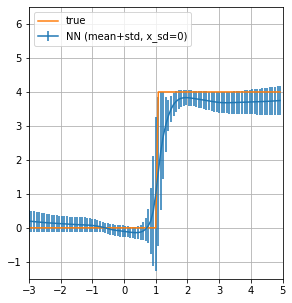

In [341]:
length = 100
start = -3
end = 5
waith = end - start
in_var = 0.1
val_x = torch.tensor([[i, in_var] for i in np.arange(start,end,waith/length)])
val_y = (val_x[:,0]>1)*4

pred_y1 = model_stochastic(val_x).detach().cpu()
mu1 = pred_y1[:,0]
std1 = torch.sqrt(pred_y1[:,1] + torch.pow(model_error(val_x[:,0].view(-1,1)).detach().cpu(),2).view(-1))

# pred_y2 = model2(val_x).detach().cpu()
# mu2 = pred_y2[:,0]
# var2 = pred_y2[:,1]
# std2 = torch.sqrt(var2)


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax1.errorbar(val_x[:,0], mu1, std1, label="NN (mean+std, x_sd=0)")
ax1.plot(val_x[:,0], val_y, label="true")
ax1.grid()
ax1.legend(loc='upper left')
plt.xlim(-3, 5)
plt.ylim(-1.5, 6.5)

# ax2 = fig.add_subplot(1,2,2)
# ax2.errorbar(val_x[:,0], mu2, std2, label="NN (mean+std, x_sd=0.5)")
# ax2.plot(val_x[:,0], val_y, label="true")
# ax2.grid()
# ax2.legend(loc='upper left')
# plt.xlim(-3, 3)
# plt.ylim(-1.5, 6.5)

fig.show()